# 差异分析前的准备——数据检查

> 本节概览：
> 1. 数据预处理, 使样本间具有可比性
> 2. boxplot查看样本的基因整体表达情况
> 3. 查看不同分组的聚类情况：样本hclust 图、距离热图、PCA图、差异基因热图、相关性热图


从`featureCounts`与`Salmon`输出文件获取`counts`矩阵 在进行差异分析前需要进行数据检查，保证我们的下游分析是有意义的。

以下展示了样本hclust 图、距离热图、PCA图、前500差异性大的基因热图、相关性热图（选取了500高表达基因，防止低表达基因造成的干扰），确定我们不同样本间确实是有差异的。这些图并不是全都是必须的，它们全都是为了说明一个问题：我们的不同分组间确实存在差异。

## 1. 数据预处理, 使样本间具有可比性

```R
rm(list = ls())
options(stringsAsFactors = F)
library(FactoMineR)
library(factoextra)
library(tidyverse) # ggplot2 stringer dplyr tidyr readr purrr  tibble forcats
library(pheatmap)
library(DESeq2)
library(RColorBrewer)

#### 载入数据 设置目录
setwd("/slurm/home/admin/nlp/DL/97-bioinformatics/gene_process_for_python/data")
load(file = "1.counts.Rdata")
dir.create("2.check")
setwd("2.check")

#### 数据预处理  # (任选以下一种作为dat即可，主要是进行样本间归一化，使得样本具有可比性)
# dat <- as.data.frame(log2(edgeR::cpm(counts)+1))  #简单归一化 CPM:Counts per million
dat <- log2(tpm + 1)
# DESeq2_normalize   rld
if (F) {
    dds <- DESeqDataSetFromMatrix(
        countData = counts,
        colData = gl,
        design = ~group_list
    )
    rld <- rlog(dds, blind = FALSE)
    write.table(assay(rld), file = "Deseq2_rld.txt", sep = "\t", quote = F, col.names = NA)
    dat <- as.data.frame(assay(rld))
}

```

In [28]:
rm(list = ls())
options(stringsAsFactors = F)
library(FactoMineR)
library(factoextra)
library(tidyverse) # ggplot2 stringer dplyr tidyr readr purrr  tibble forcats
library(pheatmap)
library(DESeq2)
library(RColorBrewer)

#### 载入数据 设置目录
setwd("/slurm/home/admin/nlp/DL/97-bioinformatics/gene_process_for_python/data")
load(file = "./salmon/1.counts.Rdata")
dir.create("2.check")
setwd("2.check")


Warning message in dir.create("2.check"):
“'2.check' already exists”


In [29]:
#### 数据预处理  # (任选以下一种作为dat即可，主要是进行样本间归一化，使得样本具有可比性)
# dat <- as.data.frame(log2(edgeR::cpm(counts)+1))  #简单归一化 CPM:Counts per million

use_des_norm <- F
head(tpm)
dat <- log2(tpm + 1)
head(dat)
# DESeq2_normalize   rld
if (use_des_norm) {
    dds <- DESeqDataSetFromMatrix(
        countData = counts,
        colData = gl,
        design = ~group_list
    )
    rld <- rlog(dds, blind = FALSE)
    write.table(assay(rld),
        file = "Deseq2_rld.txt",
        sep = "\t",
        quote = F,
        col.names = NA
    )
    dat <- as.data.frame(assay(rld))
}


,RNA_mESCs,RNA_mESCs,RNA_EpiSCs
,<dbl>,<dbl>,<dbl>
0610009B22Rik,24.140458,33.902226,14.086120
0610010F05Rik,7.610479,3.760170,6.566272
0610010K14Rik,107.183811,102.181068,86.636459
0610012G03Rik,53.435994,50.305690,14.955560
0610030E20Rik,6.745598,4.945462,5.916453
0610040J01Rik,0.209327,0.000000,0.574332


,RNA_mESCs,RNA_mESCs,RNA_EpiSCs
,<dbl>,<dbl>,<dbl>
0610009B22Rik,4.6519390,5.125247,3.9151499
0610010F05Rik,3.1060935,2.251013,2.9195826
0610010K14Rik,6.7573408,6.689034,6.4534593
0610012G03Rik,5.7664890,5.681047,3.9959873
0610030E20Rik,2.9533766,2.571789,2.7900324
0610040J01Rik,0.2742044,0.000000,0.6547398


## 2. boxplot查看样本的基因整体表达情况
```R
### boxplot 查看样本的基因整体表达情况
boxplot(dat,col=color, ylab="dat", main=" normalized data ",
        outline = F, notch = F)
```

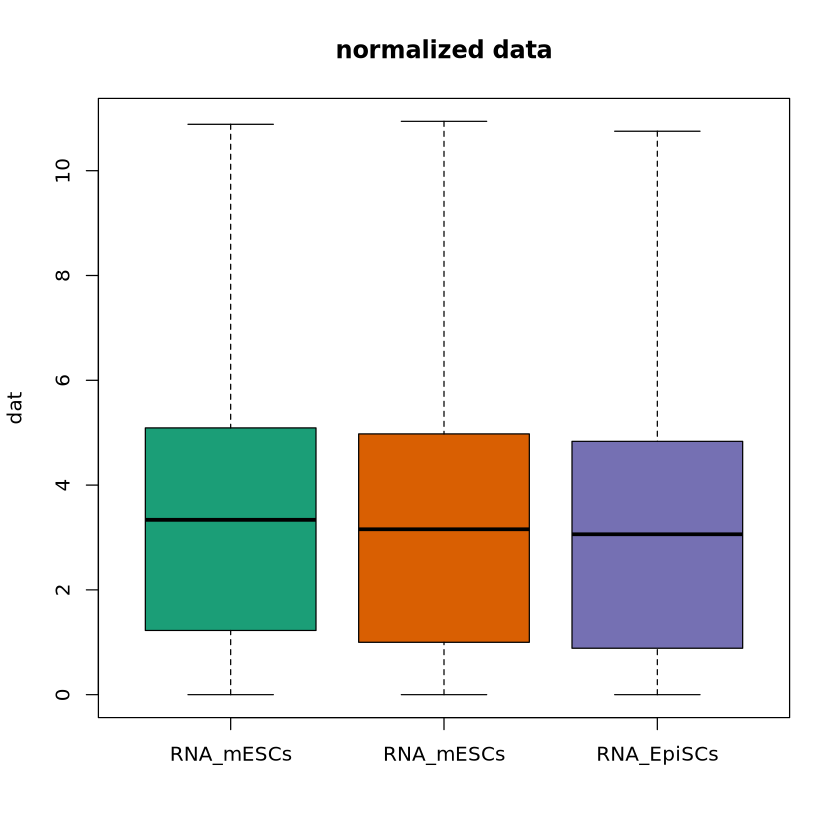

In [30]:
### boxplot 查看样本的基因整体表达情况
color <- brewer.pal(3, "Dark2")
boxplot(dat,
    col = color, #  c("red", "blue"),
    ylab = "dat",
    main = " normalized data ",
    outline = F,
    notch = F
)


## 3. 查看不同分组的聚类情况：
绘制样本hclust 图、距离热图、PCA图、差异基因热图、相关性热图：

```R
###################### hclust and Heatmap of the sample-to-sample distances ###########################
sampleDists <- dist(t(dat))   #dist默认计算矩阵行与行的距离， 因此需要转置
sampleDistMatrix <- as.matrix(sampleDists)  
colors <- colorRampPalette( rev(brewer.pal(9, "Blues")) )(255)  #选取热图的颜色
p0 <- pheatmap::pheatmap(sampleDistMatrix,
                         fontsize=7,
                         clustering_distance_rows=sampleDists,
                         clustering_distance_cols=sampleDists,
                         angle_col=45,
                         col=colors)
ggsave(p0,filename = 'check_dist.pdf',width = 7.5,height =6)
dev.off()

pdf("check_hclust.pdf")
plot(hclust(sampleDists))
dev.off()

################################# PCA检测 #####################################
#PCA查看实验和对照组情况
dat.pca <- PCA(t(dat) , graph = F) 
pca <- fviz_pca_ind(dat.pca,
                    title = "Principal Component Analysis",
                    legend.title = "Groups",
                    geom.ind = c("point", "text"), 
                    pointsize = 1.5,
                    labelsize = 4,
                    col.ind = group_list, # 分组上色
                    axes.linetype=NA,  # remove axeslines
                    mean.point=F#去除分组中心点
                    ) + 
  coord_fixed(ratio = 1)+  #坐标轴的纵横比
  xlab(paste0("PC1 (",round(percentVar[1,'variance.percent'],1),"%)")) +
  ylab(paste0("PC2 (",round(percentVar[2,'variance.percent'],1),"%)"))
#若用 rld 数据，还可使用DESeq2自带函数 
#pca <- plotPCA(rld, ntop = 500, intgroup=c("group_list"))
ggsave(pca, filename = 'check_PCA.pdf',width = 7.5,height =6)
dev.off()

####################### heatmap检测——取500差异大的基因 ##########################################
cg <- names(tail(sort(apply(dat,1,sd)),500)) #取每一行的方差，从小到大排序，取最大的500个
p1 <- pheatmap::pheatmap(n,show_colnames =T,show_rownames = F,
                         fontsize=7,
                         legend_breaks = -3:3,
                         #scale = "row",
                         angle_col=45,
                         annotation_col=gl) 
}
ggsave(p1,filename = 'check_heatmap_top500_sd.pdf',width = 7.5,height =6)
dev.off()

#######################样本相关性检测————取500高表达基因##################################
dat_500 <- dat[names(sort(apply(dat,1,mad),decreasing = T)[1:500]),]#取高表达量前500基因
M <- cor(dat_500)

p2 <-pheatmap::pheatmap(M,
                   show_rownames = T,
                   angle_col=45,
                   fontsize=7,
                   annotation_col = gl ) }
ggsave(p2,filename = 'check_cor_top500.pdf',width = 7.5,height =6)

```

In [31]:
colnames(dat) <- c("RNA_mESCs_1", "RNA_mESCs_2", "RNA_mESCs_3")
colnames(dat)


[1] "RNA_mESCs_1" "RNA_mESCs_2" "RNA_mESCs_3"

            RNA_mESCs_1 RNA_mESCs_2
RNA_mESCs_2    59.27513            
RNA_mESCs_3   182.53491   190.92927

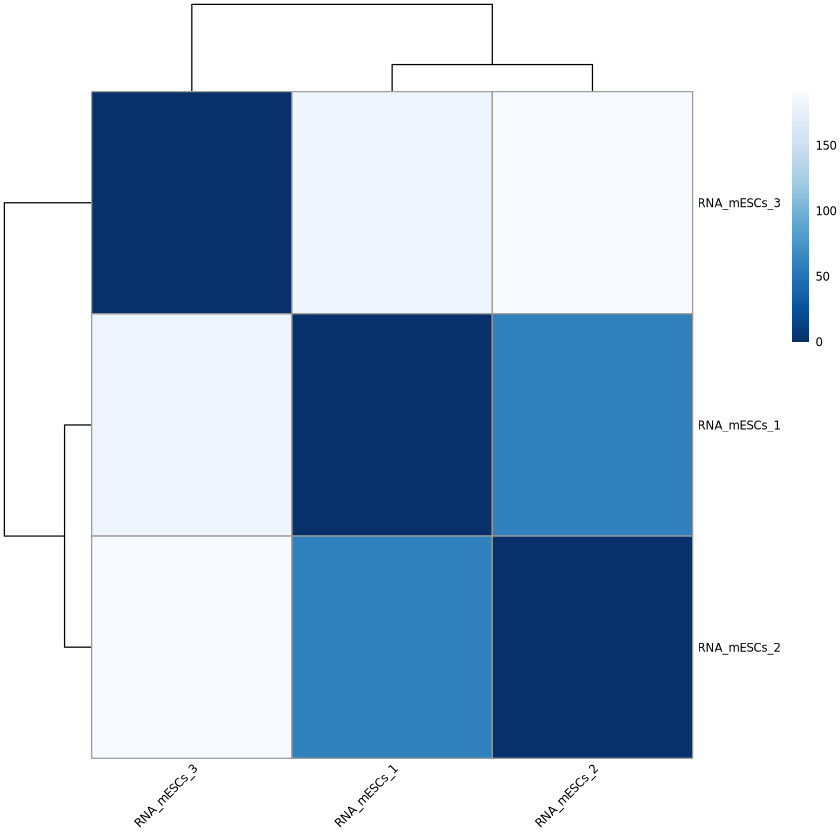

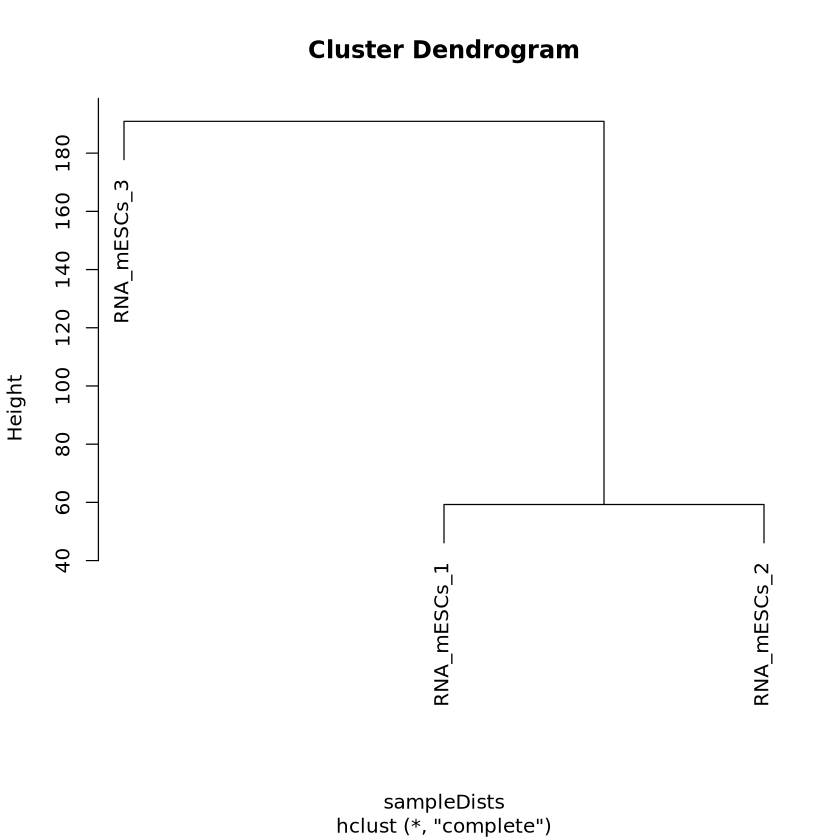

In [32]:
sampleDists <- dist(t(dat)) # dist默认计算矩阵行与行的距离， 因此需要转置
sampleDists
sampleDistMatrix <- as.matrix(sampleDists)
colors <- colorRampPalette(rev(brewer.pal(9, "Blues")))(255) # 选取热图的颜色
p0 <- pheatmap::pheatmap(sampleDistMatrix,
    fontsize = 7,
    clustering_distance_rows = sampleDists,
    clustering_distance_cols = sampleDists,
    angle_col = 45,
    col = colors
)
ggsave(p0, filename = "check_dist.pdf", width = 7.5, height = 6)
# dev.off()

# pdf("check_hclust.pdf")
plot(hclust(sampleDists))


In [33]:
hclust(sampleDists)



Call:
hclust(d = sampleDists)

Cluster method   : complete 
Distance         : euclidean 
Number of objects: 3 


In [36]:
group_list <- c("1", "1", "2")


In [42]:
################################# PCA检测 #####################################
# PCA查看实验和对照组情况
dat.pca <- PCA(t(dat),
    graph = F
)
pca <- fviz_pca_ind(dat.pca,
    title = "Principal Component Analysis",
    legend.title = "Groups",
    geom.ind = c("point", "text"),
    pointsize = 1.5,
    labelsize = 4,
    col.ind = group_list, # 分组上色
    axes.linetype = NA, # remove axeslines
    mean.point = F # 去除分组中心点
) + coord_fixed(ratio = 1) #+ # 坐标轴的纵横比
# xlab(paste0("PC1 (", round(percentVar[1, "variance.percent"], 1), "%)")) +
# ylab(paste0("PC2 (", round(percentVar[2, "variance.percent"], 1), "%)"))
# 若用 rld 数据，还可使用DESeq2自带函数
# pca <- plotPCA(rld, ntop = 500, intgroup=c("group_list"))
ggsave(pca, filename = "check_PCA.pdf", width = 7.5, height = 6)
# dev.off()


Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_segment()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_segment()`).”


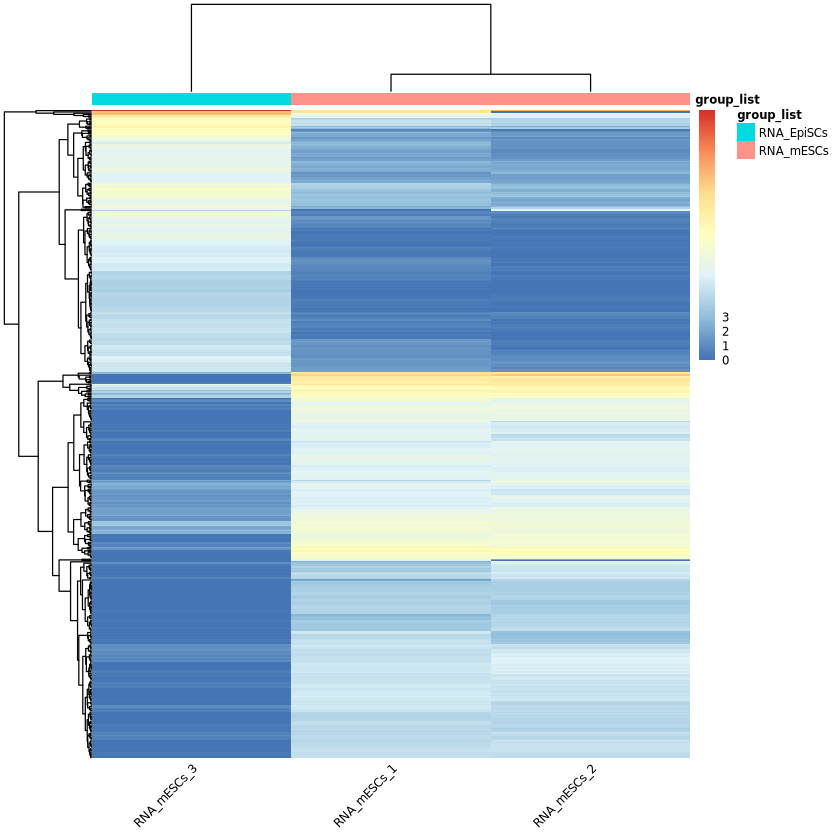

In [62]:
####################### heatmap检测——取500差异大的基因 ##########################################
dat_500 <- dat[names(sort(apply(dat, 1, sd), decreasing = T)[1:500]), ] # 取每一行的方差，从小到大排序，取最大的500个
p1 <- pheatmap::pheatmap(
    dat_500,
    show_colnames = T,
    show_rownames = F,
    fontsize = 7,
    legend_breaks = -3:3,
    # scale = "row",
    angle_col = 45,
    annotation_col = gl
)

ggsave(p1,
    filename = "check_heatmap_top500_sd.pdf",
    width = 7.5,
    height = 6
)
# dev.off()


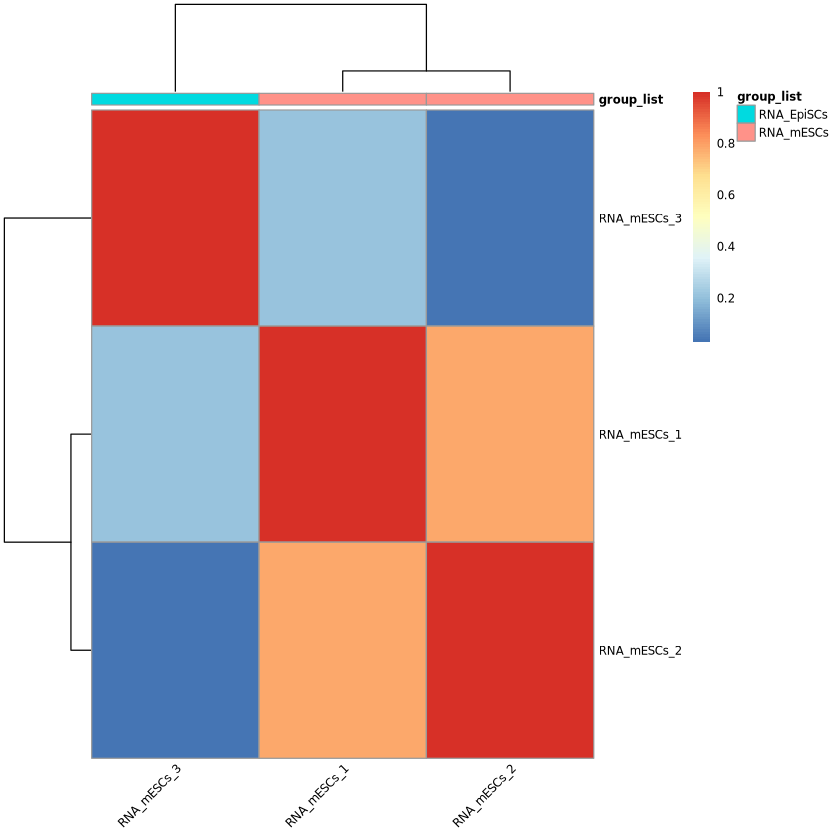

In [53]:
####################### 样本相关性检测————取500高表达基因##################################
dat_500 <- dat[names(sort(apply(dat, 1, mad), decreasing = T)[1:500]), ] # 取高表达量前500基因
M <- cor(dat_500)

p2 <- pheatmap::pheatmap(M,
    show_rownames = T,
    angle_col = 45,
    fontsize = 7,
    annotation_col = gl
)
ggsave(p2, filename = "check_cor_top500.pdf", width = 7.5, height = 6)


> 从以上各图可以看出，我们进行归一化后的数据在各样本间分布一致，因此各样本间是可比较的。各种聚类可视化图也可以明显看出我们的两个分组之间确实存在有很大的差异，组间样品是分开的，组内是聚在一起的，因此我们就可以自信地进行下一步的差异分析啦